# CNN Based Models
Convolutional Neural Network are great at spotting visual features.
In the case of speech recognition, one good visual representation of audio data is the spectrogram, which shows the magnitude of the audio signal for each time frame and for each frequency.
One of the most popular ways of extracting meaningful features  from audio data is to apply a Mel Filterbank and then to apply Discrete Cosine Transform to the found features, and obtaining so the Mel Frequency Cepstral Coefficients (for speech, generally only the first 13 features are kept, which are the most important for detecting words). This is a great way to represent and to compress audio features. 

## Tasks definitions:
Each model is trained on three different tasks:
 - 10 core KWS + unknown + silence; 
 - 20 core + (unknown+silence); 
 - 35core + silence;

In [1]:
import tensorflow as tf
import os
import pathlib
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

from models import *
from IPython import display
from utils import *

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform


from hyperparams import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import *
sns.set_context("notebook")

# Set seed for experiment reproducibility
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)


2021-08-26 00:34:03.030495: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# _SMOKE_SIZE_ = 2000
_SMOKE_SIZE_ = -1

In [3]:
_TASKS_

['10kws+U+S', '20kws+U', '35kws']

## Import Data - Task 10kws+U+S

In [4]:
current_task = _TASKS_[1]

In [5]:
print(current_task)

20kws+U


In [6]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

Auxiliary keywords:  ['bird', 'house', 'sheila', 'wow', 'backward', 'happy', 'learn', 'bed', 'marvin', 'visual', 'dog', 'cat', 'follow', 'forward', 'tree']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'filler']
Samples in Training Set: 94824
Samples in Test Set: 9981
Samples in Validation Set: 11005


In [7]:
batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size,
                            task=current_task)

2021-08-21 20:16:43.259417: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-21 20:16:43.318954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-21 20:16:43.319401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-21 20:16:43.319445: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-21 20:16:43.322200: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-21 20:16:43.322322: I tensorflow/stream_executor/platf

Train steps: 1482
Validations steps: 172
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         9.9384226e-04, -1.8264791e-03, -1.3679760e-03],
       [ 1.2683159e-01,  2.5701396e-02,  1.0887787e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.4857543e-03, -7.1583455e-03, -9.2824064e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.4375829e-03,  1.6776971e-03,  1.4253149e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.8674760e-04,  2.7202745e-03, -4.6692067e-04],
       [ 1.2094945e-03,  5.4024078e-04,  5.1403418e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([ 9, 13, 18, 16, 20, 20, 20,  6, 20,  5,  3,  5, 18, 13, 15, 20, 13,
        8,  1,  7, 

2021-08-21 20:16:43.329226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-21 20:16:43.329608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-21 20:16:43.337736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-21 20:16:43.337941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), b

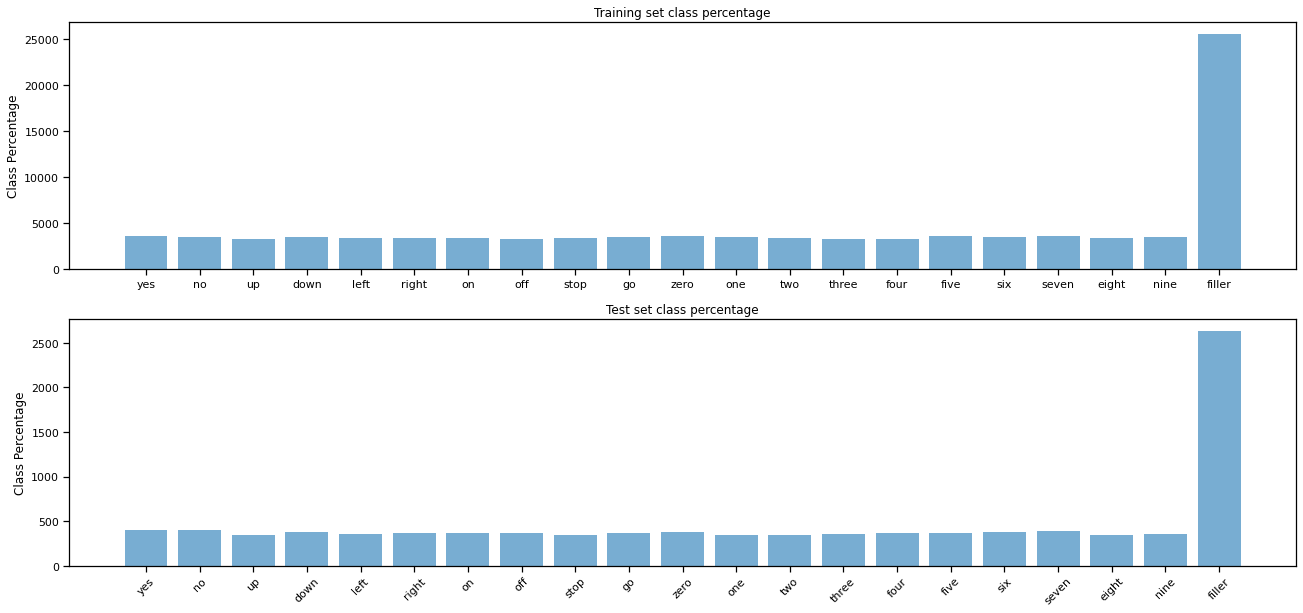

In [8]:
visualize_class_balance(y_train, y_test, output_classes)

# Baseline Models
`cnn-trad-fpool3`, `cnn-one-fstride4` from https://static.googleusercontent.com/media/research.google.com/it//pubs/archive/43969.pdf

## Model 1 (cnn-trad-fpool3)

input dimensions are: (time_dimension, frequency_dimension)

- CONV2D Layer: n_filters=64, filter_size = (20, 8), stride = (1,1);
- MaxPool2D: pool_dimension = (1, 3);
- CONV2D Layer: n_filters=64, filter_size = (10, 4), stride = (1,1);
- Dense Layer with linear activation and 32 units;
- Dense layer with ReLu activation and  128 units;
- Output Layer with n_outputs units and softmax activation.



In [9]:
model_cnn_trad_fpool3 = cnn_trad_fpool3(train_dataset,
                                        output_classes,
                                       model_name ="model_cnn_trad_fpool3")
model_cnn_trad_fpool3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_trad_fpool3.summary()

Input shape: (16000,)
Model: "model_cnn_trad_fpool3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc (MFCC)                  (None, 98, 39, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 39, 1)         4         
_________________________________________________________________
spec_augment (SpecAugment)   (None, 98, 39, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 79, 32, 64)        10304     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)      

In [10]:
# ## Learning Rate Scheduler: decides how to make the learning rate decrease with time
# # Example: start with lr=0,001 and decrease by a factor of 0.4 every 10 epochs
# def scheduler(epoch, lr):
#     return 0.4*(epoch%10) * lr
    
# tf.keras.callbacks.LearningRateScheduler(
#     schedule, verbose=0
# )

In [22]:
for i in train_dataset.take(1):
    w= i[0]
X = MFCC(return_deltas=False, n_cepstral=40)(w)
X = layers.BatchNormalization(axis=-1)(X)
X = SpecAugment()(X)
# X = layers.Conv2D(64, (20, 8), activation='relu')(X)
# X.shape

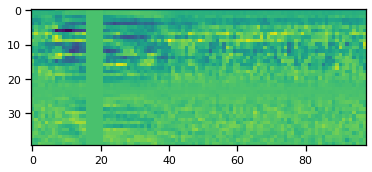

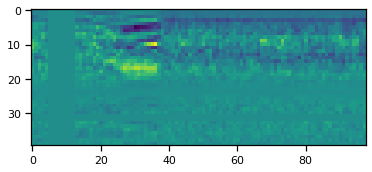

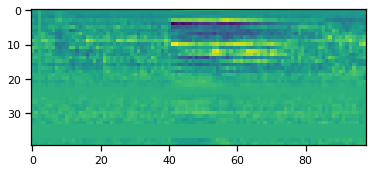

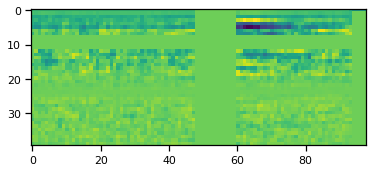

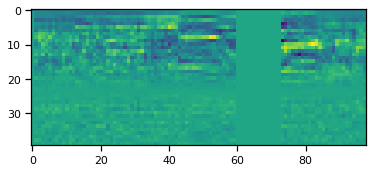

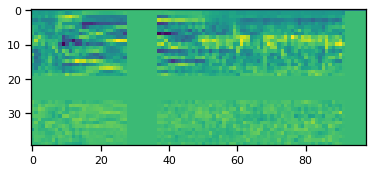

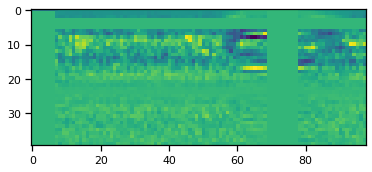

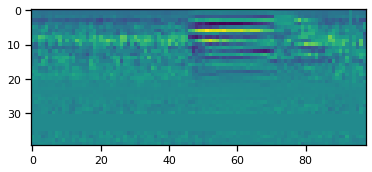

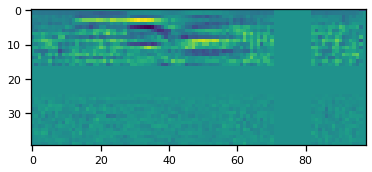

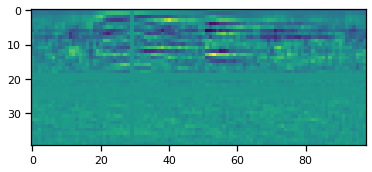

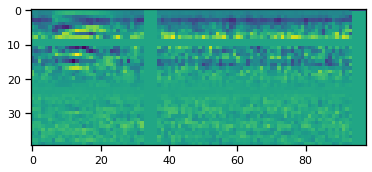

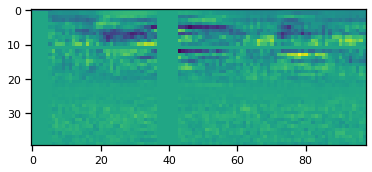

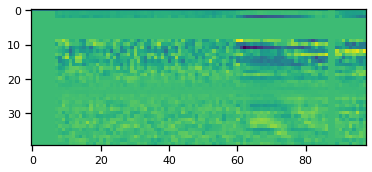

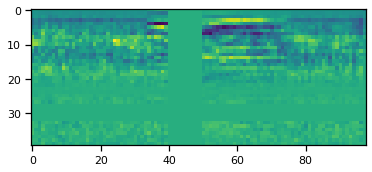

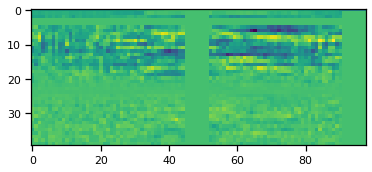

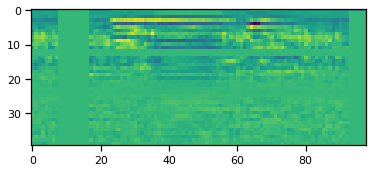

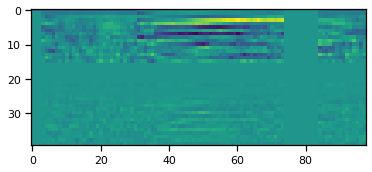

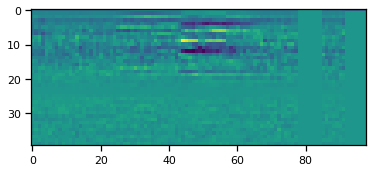

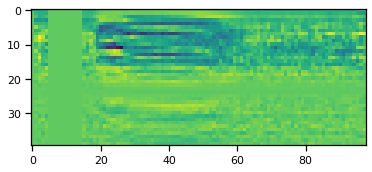

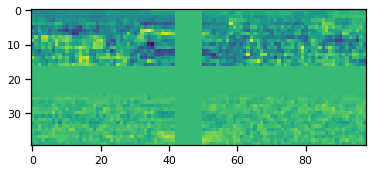

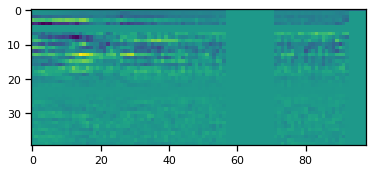

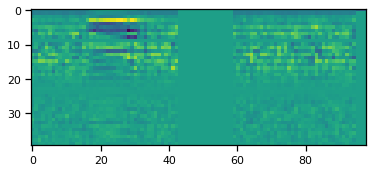

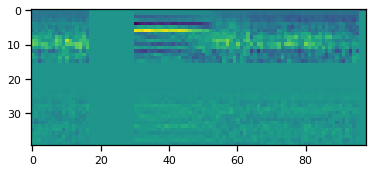

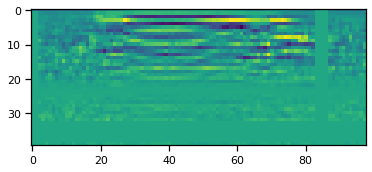

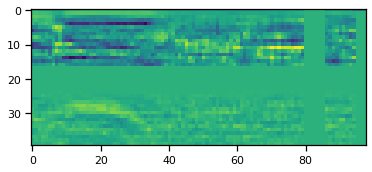

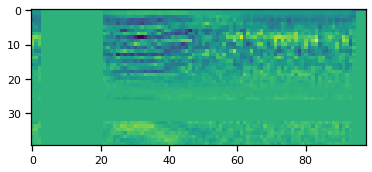

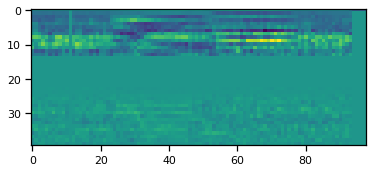

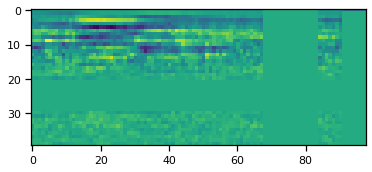

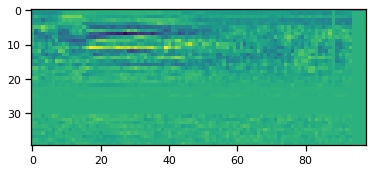

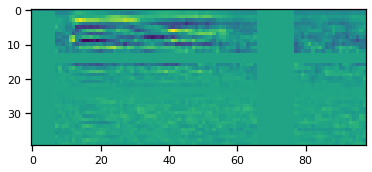

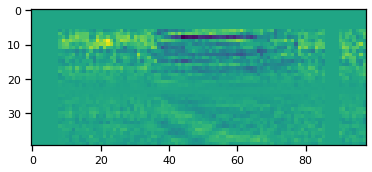

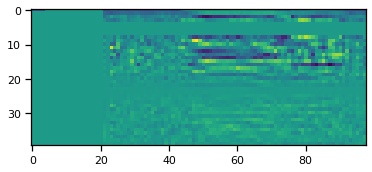

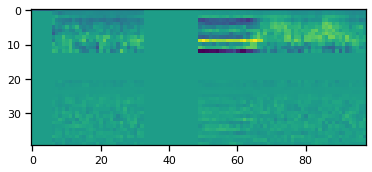

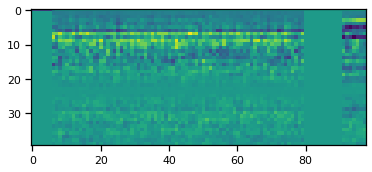

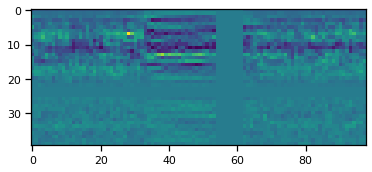

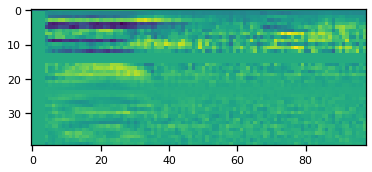

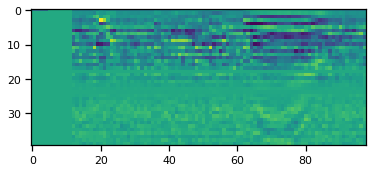

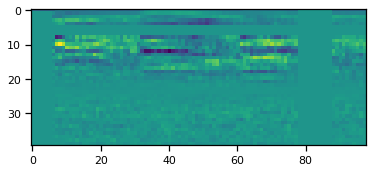

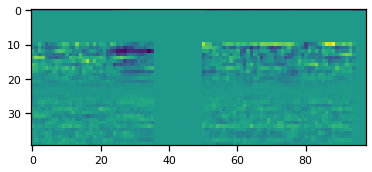

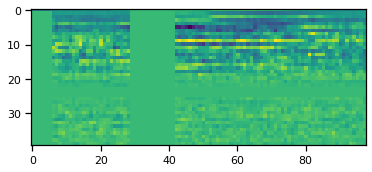

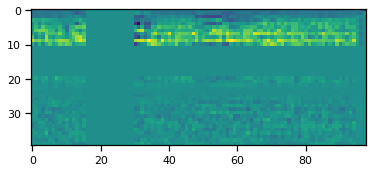

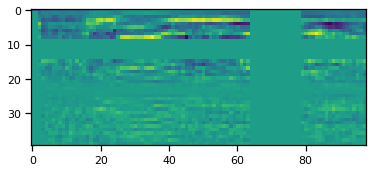

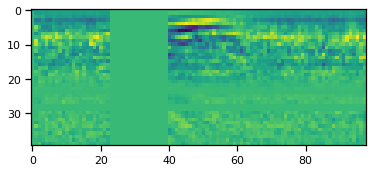

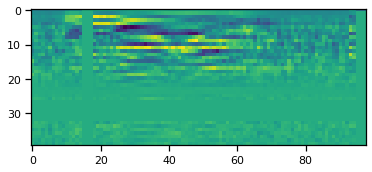

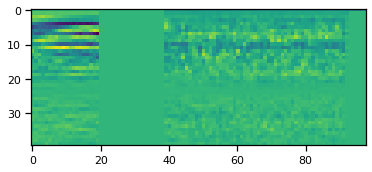

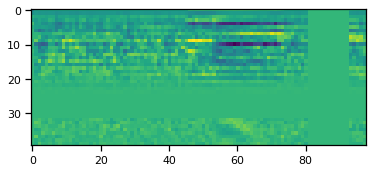

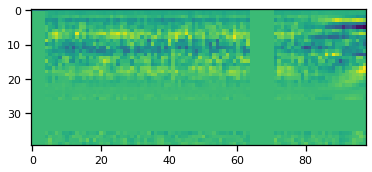

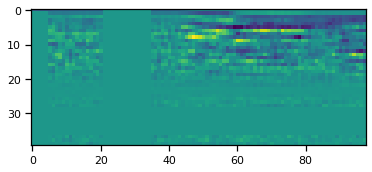

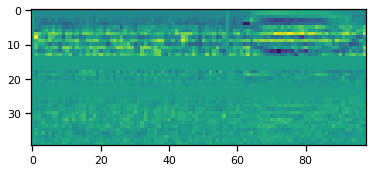

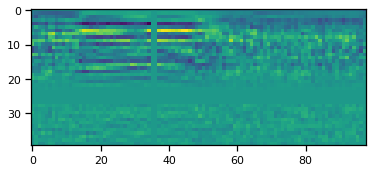

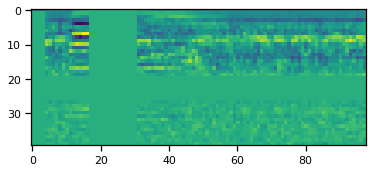

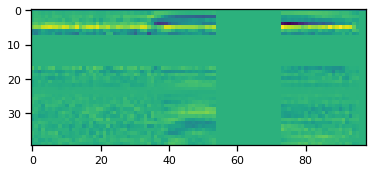

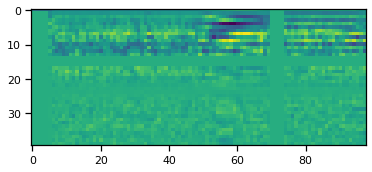

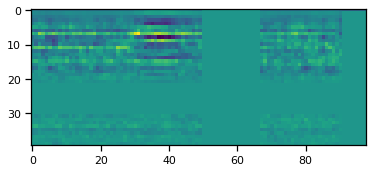

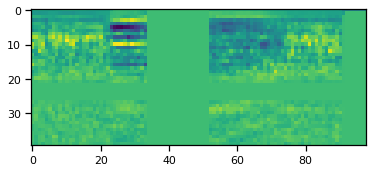

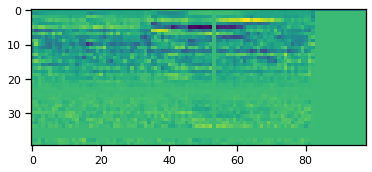

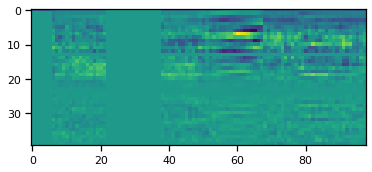

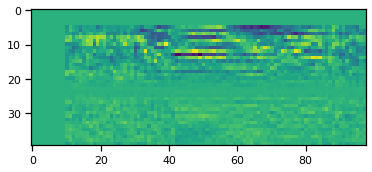

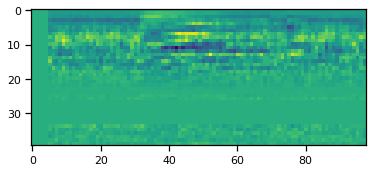

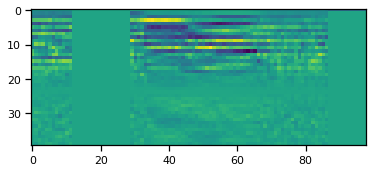

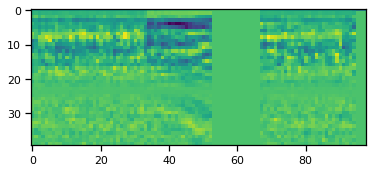

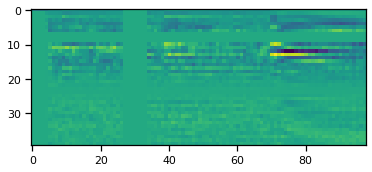

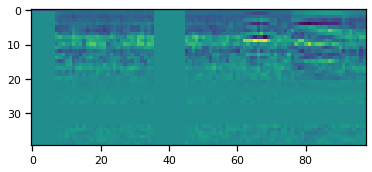

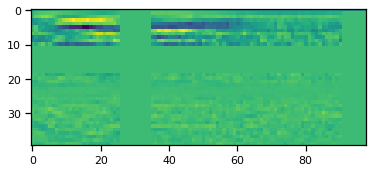

In [23]:
for i in X:
    plt.imshow(i[...,0].numpy().T)
    plt.show()

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_trad_fpool3.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-21 19:46:32.127090: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-21 19:46:32.171024: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-08-21 19:46:32.539899: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-21 19:46:32.813432: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


 232/1482 [===>..........................] - ETA: 1:40 - loss: 4.8082 - accuracy: 0.2637

KeyboardInterrupt: 

In [12]:
#save model
#cnn_trad_fpool3
model_cnn_trad_fpool3.save(_MODELS_DIR_/current_task/(model_cnn_trad_fpool3.name+'.h5'))

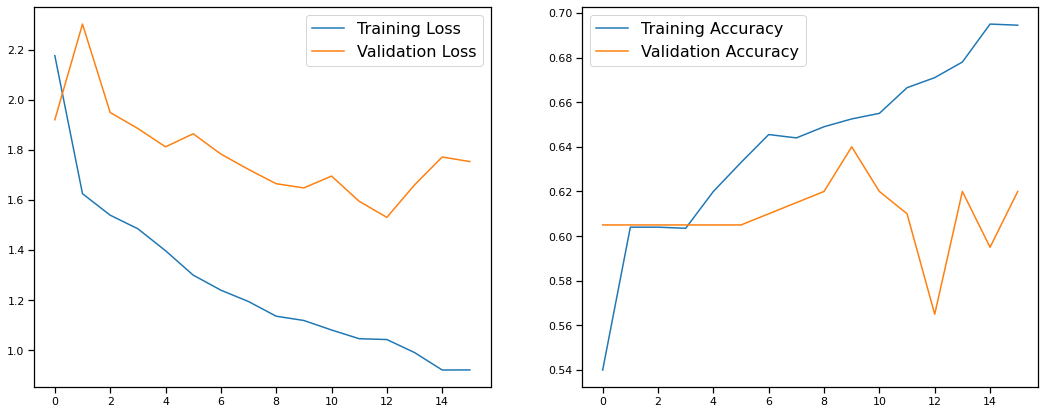

In [13]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [19]:
def nice_conf_matrix(model, test_dataset, test_steps, y_test, current_task, form=".3f"):
    y_scores = model.predict(test_dataset, steps=test_steps)[:len(y_test)]
    y_pred = np.array(np.argmax(y_scores, axis=1))
    y_true = np.array(y_test)
    # compute test accuracy
    test_acc = sum(y_pred == y_true) / len(y_true)
    print(f'Test set accuracy: {test_acc:.3%}')

    confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
    plt.figure(figsize=(13, 10))
    sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
                annot=True, fmt =form)
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title(f"Model: {model.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
    plt.savefig(_MODELS_DIR_/current_task/f'{model.name}.png', dpi=300)
    plt.show()

Test set accuracy: 54.000%


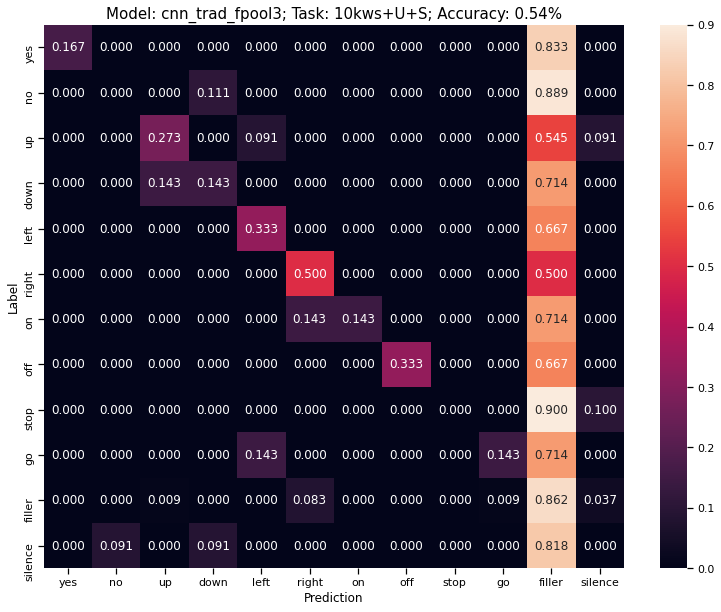

In [62]:
nice_conf_matrix(model_cnn_trad_fpool3, test_dataset, test_steps, y_test, current_task)

In [63]:
fpr, fnr, roc_auc = get_fpr_fnr_aucs(y_test, y_scores, output_classes)

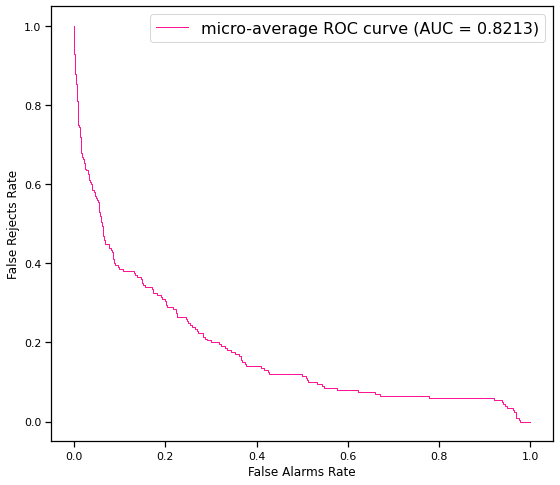

In [64]:
plt.figure(figsize=(9,8))
plt.plot(fpr["micro"], fnr["micro"],
         color='deeppink', linestyle='-', linewidth=1, label='micro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["micro"]))
plt.xlabel("False Alarms Rate")
plt.ylabel("False Rejects Rate")
plt.legend(fontsize=16)
plt.show()

## Model 2 (cnn-one-fstride4)

input dimensions are: (time_dimension, frequency_dimension)

- CONV2D Layer: n_filters=186, filter_size = (32, 8), stride = (1,4);
- Dense Layer with linear activation and 32 units;
- Dense layer with ReLu activation and  128 units;
- Dense layer with ReLu activation and  128 units;
- Output Layer with n_outputs units and softmax activation.


In [55]:
model_cnn_one_fstride4 = cnn_one_fstride4(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = "cnn_one_fstride4",
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)

model_cnn_one_fstride4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_one_fstride4.summary()

Input shape: (16000,)
Model: "cnn_one_fstride4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc_1 (MFCC)                (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 40, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 67, 9, 186)        47802     
_________________________________________________________________
flatten_1 (Flatten)          (None, 112158)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3589088   
_________________________________________________________________
dense_4 (Dense)             

In [56]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_one_fstride4.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30
16/16 [==============================] - 2s 68ms/step - loss: 1.8321 - accuracy: 0.5160 - val_loss: 2.3459 - val_accuracy: 0.6050
Epoch 2/30
16/16 [==============================] - 1s 41ms/step - loss: 1.5251 - accuracy: 0.6145 - val_loss: 2.0905 - val_accuracy: 0.6000
Epoch 3/30
16/16 [==============================] - 1s 40ms/step - loss: 1.3287 - accuracy: 0.6360 - val_loss: 1.8177 - val_accuracy: 0.5950
Epoch 4/30
16/16 [==============================] - 1s 39ms/step - loss: 1.1945 - accuracy: 0.6405 - val_loss: 1.8750 - val_accuracy: 0.5850
Epoch 5/30
16/16 [==============================] - 1s 46ms/step - loss: 1.0584 - accuracy: 0.6700 - val_loss: 1.8216 - val_accuracy: 0.6100
Epoch 6/30
16/16 [==============================] - 1s 46ms/step - loss: 1.0387 - accuracy: 0.6715 - val_loss: 1.8836 - val_accuracy: 0.5550
Epoch 00006: early stopping


In [58]:
#save model
model_cnn_one_fstride4.save(_MODELS_DIR_/current_task/(model_cnn_one_fstride4.name+'.h5'))

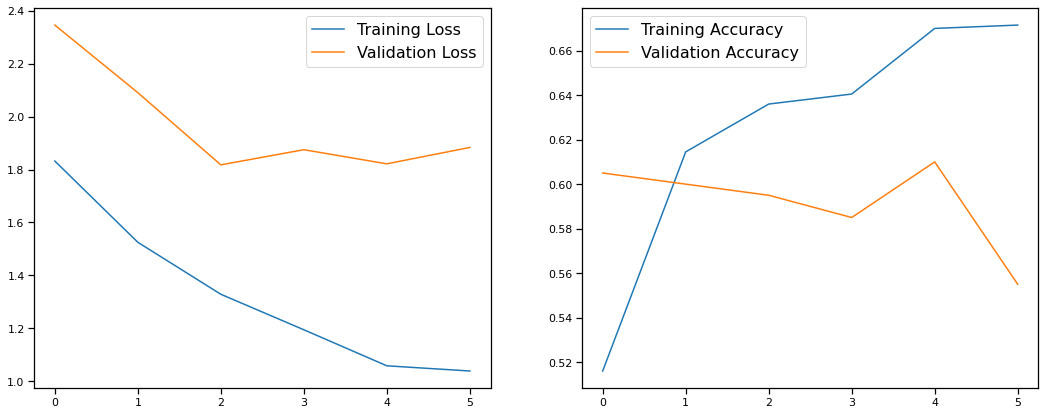

In [59]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

Test set accuracy: 58.000%


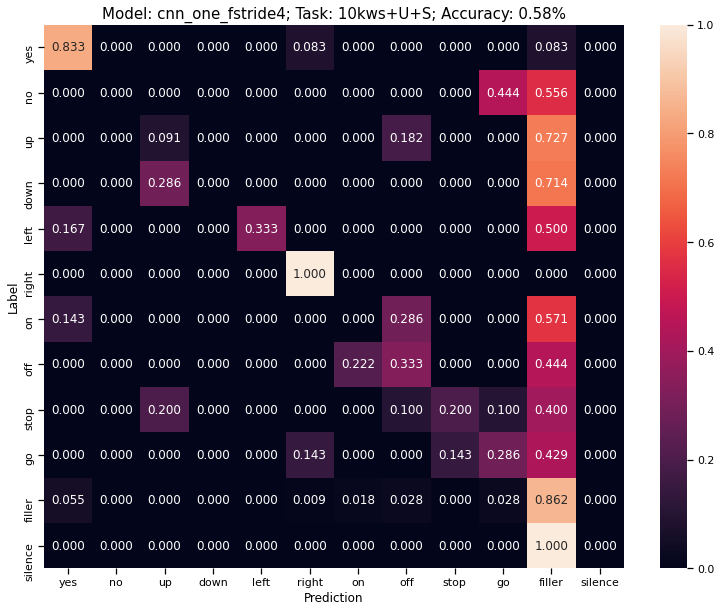

In [65]:
nice_conf_matrix(model_cnn_one_fstride4, test_dataset, test_steps, y_test, current_task)

## Residual CNN Network Models

In [24]:
model_res_net = kws_res_net(train_dataset, output_classes)

model_res_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_res_net.summary()

Input shape: (16000,)
Model: "ResNetKWS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
mfcc_5 (MFCC)                   (None, 98, 120, 1)   0           input_2[0][0]                    
__________________________________________________________________________________________________
spec_augment_4 (SpecAugment)    (None, 98, 120, 1)   0           mfcc_5[0][0]                     
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 98, 120, 1)   4           spec_augment_4[0][0]             
____________________________________________________________________

In [25]:
#Train the model
EPOCHS = 50
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_res_net.fit(
    train_dataset, 
    validation_data=valid_dataset,  
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/50
  89/1482 [>.............................] - ETA: 3:10 - loss: 4.6400 - accuracy: 0.2014

KeyboardInterrupt: 

In [69]:
#save model
model_res_net.save(_MODELS_DIR_/current_task/(model_res_net.name+'.h5'))

/home/rmazzier/Desktop/HDA/tf_venv/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


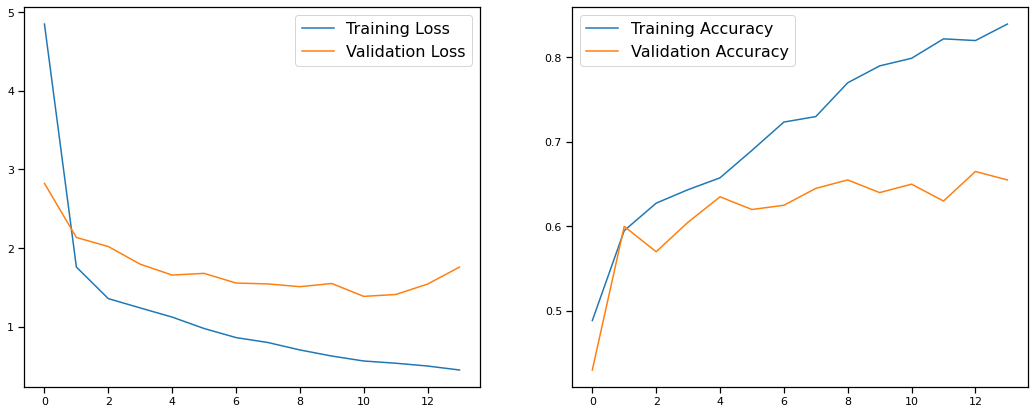

In [73]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

Test set accuracy: 64.500%


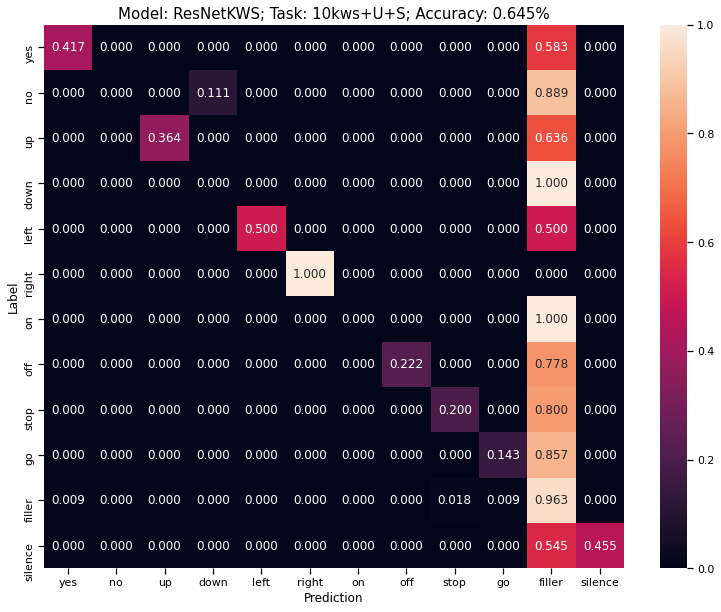

In [74]:
nice_conf_matrix(model_res_net, test_dataset, test_steps, y_test, current_task)

## Import data: 35keywords task

In [9]:
current_task = '35kws'
_SMOKE_SIZE_ = 2000

In [10]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

X_train, y_train, X_valid, y_valid, X_test, y_test = get_smoke_sized(X_train, 
                                                                     y_train, 
                                                                     X_valid, 
                                                                     y_valid, 
                                                                     X_test, 
                                                                     y_test, 
                                                                     smoke_size=_SMOKE_SIZE_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Core keywords:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']

Auxiliary keywords:  []

Output Classes:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']
Samples in Training Set: 2000
Samples in Test Set: 200
Samples in Validation Set: 200


In [11]:
batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset, test_steps = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size)

Train steps: 32
Validations steps: 4
Test steps: 4
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 2.18555611e-02,  9.99018550e-04, -1.14238821e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.38320790e-03, -2.47316994e-03, -6.69192523e-04],
       [-6.61726594e-02,  2.43558735e-02,  8.62770155e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.25175857e-03,  1.32023403e-03,  5.37192868e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.90959720e-02,  1.64099038e-04,  1.77427139e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.19251374e-04, -2.82285357e-04,  2.78732623e-05]], dtype=float32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([23, 32,  5, 26, 29, 25, 30,  8, 22, 22, 3

In [12]:
y_test

array([ 2, 31, 14, 20,  5, 32, 19, 22, 22, 20, 33, 22,  0, 15,  3,  6, 33,
       25,  2,  6, 14, 28, 17, 18,  8, 27,  8,  6, 23,  5,  9, 32,  3, 23,
        1, 30, 23, 12, 14, 29, 31, 17, 33, 17, 24, 33, 30, 18, 20, 30, 27,
        0,  9, 32, 10, 22,  7, 23, 16,  3, 17, 22, 30,  2,  4, 18, 22,  3,
       13,  8, 31, 27,  9,  2, 20, 31, 15,  8,  9,  8, 14, 32, 29, 11,  2,
       32, 21, 32, 33, 27, 31, 29, 27, 34, 17, 12, 32, 29,  6,  6,  0, 12,
        1, 30, 29, 23, 26, 10,  7, 31,  1, 32,  8,  4, 27,  9, 20, 34, 12,
        9, 21,  6, 19, 14, 28, 16, 33, 10, 31,  8,  0, 32, 29, 27,  6, 24,
       27,  2,  1, 14, 17, 30, 33,  3, 14, 13,  0,  5,  5, 19, 19, 20, 22,
       14, 18,  5, 28,  4, 22, 31,  3,  3, 26,  3,  0,  8, 13, 29,  4, 18,
       26,  1, 24, 10,  2, 10,  4,  9, 32, 22, 30,  2, 17, 30,  7, 30,  2,
        8, 14,  4, 34,  0,  8, 20, 14, 16, 27, 26,  5, 24])

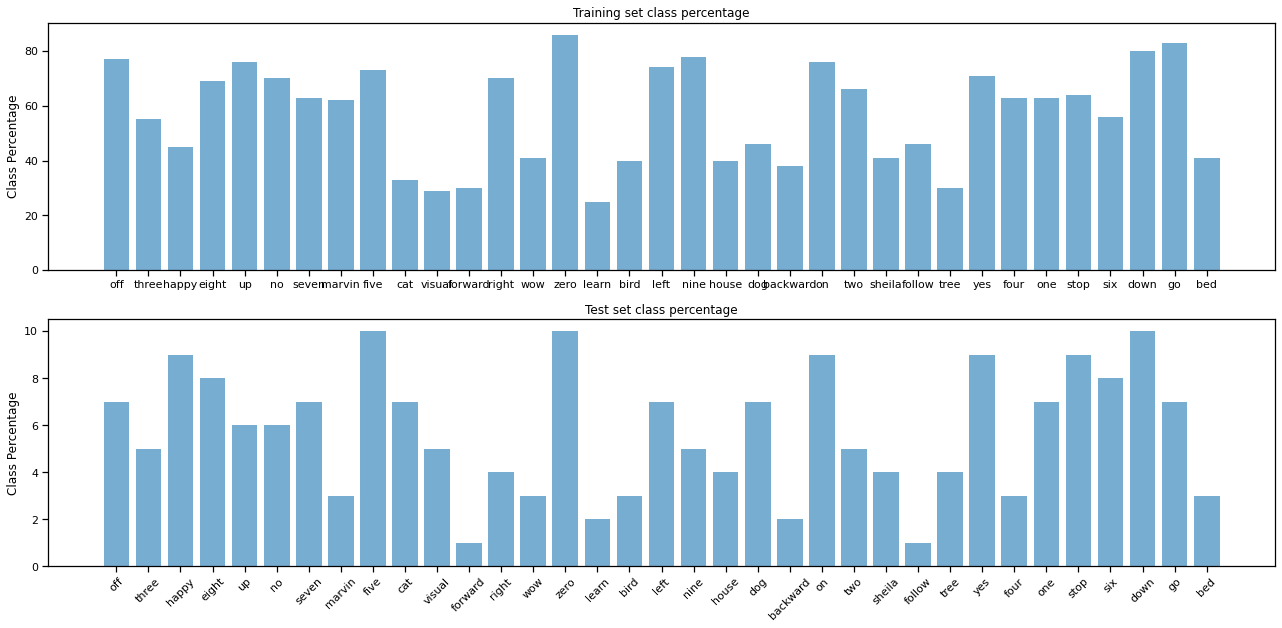

In [13]:
visualize_class_balance(y_train, y_test, output_classes)

## cnn_trad_fpool3

In [14]:
n_mfcc=40
# n_filters=[20,30,40,50]
n_filters = 40
mfcc_deltas=False
win_size = 400
hop_size=160
model_name = "cnn_trad_fpool3"

model_cnn_trad_fpool3 = cnn_trad_fpool3(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = model_name,
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)
model_cnn_trad_fpool3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_trad_fpool3.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-19 20:58:23.409636: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-19 20:58:23.508340: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-19 20:58:23.755698: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-19 20:58:23.756877: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-19 20:58:24.033157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


32/32 [==============================] - 4s 51ms/step - loss: 13.3861 - accuracy: 0.0300 - val_loss: 3.5087 - val_accuracy: 0.0550
Epoch 2/30
32/32 [==============================] - 1s 37ms/step - loss: 3.5157 - accuracy: 0.0425 - val_loss: 3.5186 - val_accuracy: 0.0350
Epoch 3/30
32/32 [==============================] - 1s 34ms/step - loss: 3.5130 - accuracy: 0.0430 - val_loss: 3.5203 - val_accuracy: 0.0350
Epoch 4/30
32/32 [==============================] - 1s 36ms/step - loss: 3.5118 - accuracy: 0.0430 - val_loss: 3.5209 - val_accuracy: 0.0350
Epoch 00004: early stopping


In [16]:
#save model
#cnn_trad_fpool3
model_cnn_trad_fpool3.save(_MODELS_DIR_/current_task/(model_cnn_trad_fpool3.name+'.h5'))

## trad_one_fstride4

In [23]:
n_mfcc=40
# n_filters=[20,30,40,50]
n_filters = 40
mfcc_deltas=False
win_size = 400
hop_size=160
model_name = "cnn_one_fstride4"

model_cnn_one_fstride4 = cnn_one_fstride4(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = model_name,
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)
model_cnn_one_fstride4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
model_cnn_one_fstride4.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30
32/32 [==============================] - 2s 43ms/step - loss: 38.0759 - accuracy: 0.0340 - val_loss: 3.6395 - val_accuracy: 0.0550
Epoch 2/30
32/32 [==============================] - 1s 21ms/step - loss: 3.5552 - accuracy: 0.0335 - val_loss: 3.5462 - val_accuracy: 0.0650
Epoch 3/30
32/32 [==============================] - 1s 21ms/step - loss: 3.5408 - accuracy: 0.0360 - val_loss: 3.5364 - val_accuracy: 0.0650
Epoch 4/30
32/32 [==============================] - 1s 21ms/step - loss: 3.5306 - accuracy: 0.0355 - val_loss: 3.5312 - val_accuracy: 0.0650
Epoch 5/30
32/32 [==============================] - 1s 22ms/step - loss: 3.5234 - accuracy: 0.0315 - val_loss: 3.5279 - val_accuracy: 0.0300
Epoch 00005: early stopping


In [25]:
#cnn_one_fst
model_cnn_one_fstride4.save(_MODELS_DIR_/current_task/(model_cnn_one_fstride4.name+'.h5'))

# ResNet

In [15]:
def kws_res_net_test(ds, output_classes, model_suffix):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
#     X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC()(X_input)
    X = SpecAugment()(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    # Stage 1 
    X = layers.Conv2D(64, (20,8), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

    # AVGPOOL 
    X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
#     X = layers.Dropout(0.2)(X)
    X = layers.Dense(len(output_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name="kws_res_net"+model_suffix)

    return model

In [16]:
model_res_net = kws_res_net(train_dataset, output_classes, model_suffix="test")

model_res_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# model_res_net.summary()

Input shape: (16000,)


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
history = model_res_net.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-21 20:16:55.828770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-21 20:16:55.863006: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-08-21 20:16:56.226740: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-21 20:16:56.316308: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-21 20:16:56.580214: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-21 20:16:56.599342: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-21 20:16:56.923914: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


1482/1482 [==============================] - 85s 55ms/step - loss: 1.6343 - accuracy: 0.5048 - val_loss: 1.2073 - val_accuracy: 0.6108
Epoch 2/30
1482/1482 [==============================] - 77s 52ms/step - loss: 0.9882 - accuracy: 0.6875 - val_loss: 1.1018 - val_accuracy: 0.6629
Epoch 3/30
1482/1482 [==============================] - 75s 51ms/step - loss: 0.8407 - accuracy: 0.7345 - val_loss: 0.8937 - val_accuracy: 0.7135
Epoch 4/30
1482/1482 [==============================] - 75s 51ms/step - loss: 0.7555 - accuracy: 0.7619 - val_loss: 0.8266 - val_accuracy: 0.7349
Epoch 5/30
1482/1482 [==============================] - 75s 51ms/step - loss: 0.6933 - accuracy: 0.7797 - val_loss: 0.7756 - val_accuracy: 0.7569
Epoch 6/30
1482/1482 [==============================] - 76s 52ms/step - loss: 0.6465 - accuracy: 0.7947 - val_loss: 0.7337 - val_accuracy: 0.7714
Epoch 7/30
1482/1482 [==============================] - 76s 51ms/step - loss: 0.6149 - accuracy: 0.8042 - val_loss: 0.7383 - val_accura

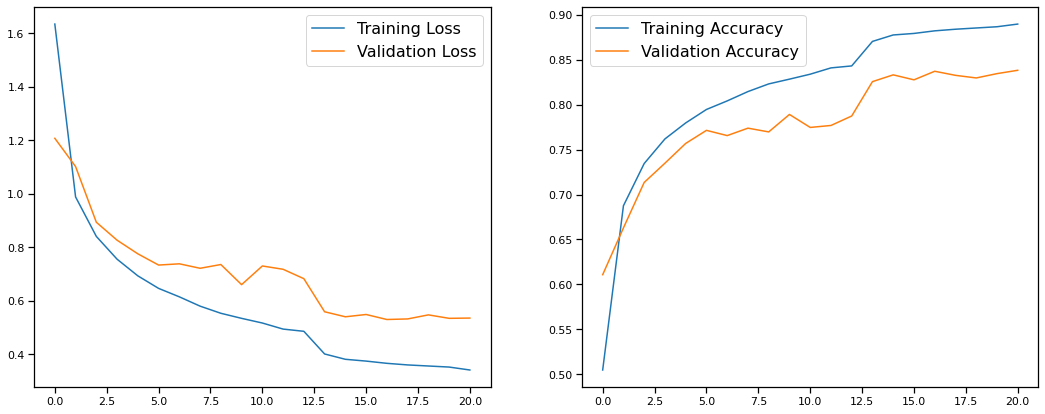

In [14]:
plot_learning_curves(history)

In [13]:
y_scores = model_res_net.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 87.166%


## test2 resnet

In [20]:
def kws_res_net_test2(ds, output_classes, model_suffix):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
#     X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC()(X_input)
    X = SpecAugment()(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    # Stage 1 
    X = layers.Conv2D(64, (20,8), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
#     X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

    # AVGPOOL 
    X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(len(output_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name="kws_res_net"+model_suffix)

    return model

model_res_net2 = kws_res_net_test2(train_dataset, output_classes, model_suffix="test")

model_res_net2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# model_res_net.summary()

Input shape: (16000,)


In [21]:
history = model_res_net2.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30
1482/1482 [==============================] - 71s 47ms/step - loss: 1.6653 - accuracy: 0.4937 - val_loss: 1.2265 - val_accuracy: 0.6122
Epoch 2/30
1482/1482 [==============================] - 69s 47ms/step - loss: 1.0281 - accuracy: 0.6727 - val_loss: 0.9893 - val_accuracy: 0.6786
Epoch 3/30
1482/1482 [==============================] - 68s 46ms/step - loss: 0.8924 - accuracy: 0.7171 - val_loss: 0.9108 - val_accuracy: 0.7074
Epoch 4/30
1482/1482 [==============================] - 70s 47ms/step - loss: 0.8109 - accuracy: 0.7440 - val_loss: 0.8594 - val_accuracy: 0.7277
Epoch 5/30
1482/1482 [==============================] - 68s 46ms/step - loss: 0.7516 - accuracy: 0.7608 - val_loss: 0.8055 - val_accuracy: 0.7455
Epoch 6/30
1482/1482 [==============================] - 68s 46ms/step - loss: 0.7095 - accuracy: 0.7732 - val_loss: 0.7825 - val_accuracy: 0.7538
Epoch 7/30
1482/1482 [==============================] - 68s 46ms/step - loss: 0.6689 - accuracy: 0.7879 - val_loss: 0.7207 -

In [31]:
y_scores = model_res_net2.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 87.146%


## Test 3

In [24]:
def kws_res_net_test3(ds, output_classes, model_suffix):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
#     X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC()(X_input)
    X = SpecAugment()(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    # Stage 1 
    X = layers.Conv2D(64, (20,8), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    
    X = convolutional_block(X, f = 2, filters = [64, 64, 64], stage = 2, block='c', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='d')
#     X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

    # AVGPOOL 
    X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(len(output_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name="kws_res_net"+model_suffix)

    return model

model_res_net3 = kws_res_net_test3(train_dataset, output_classes, model_suffix="test")

model_res_net3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [25]:
history = model_res_net3.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30
1482/1482 [==============================] - 83s 54ms/step - loss: 1.6933 - accuracy: 0.4857 - val_loss: 1.1794 - val_accuracy: 0.6242
Epoch 2/30
1482/1482 [==============================] - 78s 53ms/step - loss: 0.9966 - accuracy: 0.6859 - val_loss: 0.9391 - val_accuracy: 0.6991
Epoch 3/30
1482/1482 [==============================] - 78s 52ms/step - loss: 0.8465 - accuracy: 0.7337 - val_loss: 0.8905 - val_accuracy: 0.7254
Epoch 4/30
1482/1482 [==============================] - 78s 53ms/step - loss: 0.7613 - accuracy: 0.7590 - val_loss: 0.7929 - val_accuracy: 0.7524
Epoch 5/30
1482/1482 [==============================] - 78s 53ms/step - loss: 0.7035 - accuracy: 0.7772 - val_loss: 0.8039 - val_accuracy: 0.7507
Epoch 6/30
1482/1482 [==============================] - 79s 53ms/step - loss: 0.6588 - accuracy: 0.7904 - val_loss: 0.7249 - val_accuracy: 0.7697
Epoch 7/30
1482/1482 [==============================] - 78s 53ms/step - loss: 0.6209 - accuracy: 0.8032 - val_loss: 0.7543 -

In [26]:
y_scores = model_res_net3.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 88.889%


## Test 4

In [27]:
def kws_res_net_test4(ds, output_classes, model_suffix):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
#     X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC()(X_input)
    X = SpecAugment()(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    # Stage 1 
    X = layers.Conv2D(64, (10,10), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    
    X = convolutional_block(X, f = 2, filters = [64, 64, 64], stage = 2, block='c', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='d')
#     X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

    # AVGPOOL 
    X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(len(output_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name="kws_res_net"+model_suffix)

    return model

model_res_net4 = kws_res_net_test4(train_dataset, output_classes, model_suffix="test")

model_res_net4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model_res_net4.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

y_scores = model_res_net4.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Input shape: (16000,)
Epoch 1/30
1482/1482 [==============================] - 77s 50ms/step - loss: 1.7704 - accuracy: 0.4624 - val_loss: 1.2339 - val_accuracy: 0.6013
Epoch 2/30
1482/1482 [==============================] - 72s 49ms/step - loss: 0.9636 - accuracy: 0.6957 - val_loss: 0.8331 - val_accuracy: 0.7311
Epoch 3/30
1482/1482 [==============================] - 72s 48ms/step - loss: 0.7888 - accuracy: 0.7519 - val_loss: 0.8427 - val_accuracy: 0.7267
Epoch 4/30
1482/1482 [==============================] - 72s 48ms/step - loss: 0.7012 - accuracy: 0.7794 - val_loss: 0.7299 - val_accuracy: 0.7693
Epoch 5/30
1482/1482 [==============================] - 72s 49ms/step - loss: 0.6353 - accuracy: 0.7976 - val_loss: 0.6584 - val_accuracy: 0.7921
Epoch 6/30
1482/1482 [==============================] - 72s 49ms/step - loss: 0.5939 - accuracy: 0.8121 - val_loss: 0.6247 - val_accuracy: 0.7972
Epoch 7/30
1482/1482 [==============================] - 72s 49ms/step - loss: 0.5640 - accuracy: 0.821

## Test 5

In [28]:
def kws_res_net_test5(ds, output_classes, model_suffix):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
#     X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC()(X_input)
    X = SpecAugment()(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    # Stage 1 
    X = layers.Conv2D(64, (10,10), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    
    X = convolutional_block(X, f = 2, filters = [64, 64, 64], stage = 2, block='c', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='d')
    
    X = convolutional_block(X, f = 2, filters = [64, 64, 64], stage = 2, block='e', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='f')
#     X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

    # AVGPOOL 
    X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(len(output_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name="kws_res_net"+model_suffix)

    return model

model_res_net5 = kws_res_net_test5(train_dataset, output_classes, model_suffix="test")

model_res_net5.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model_res_net5.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

y_scores = model_res_net5.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Input shape: (16000,)
Epoch 1/30
1482/1482 [==============================] - 77s 50ms/step - loss: 1.7175 - accuracy: 0.4821 - val_loss: 1.1896 - val_accuracy: 0.6208
Epoch 2/30
1482/1482 [==============================] - 74s 50ms/step - loss: 0.9252 - accuracy: 0.7095 - val_loss: 0.9052 - val_accuracy: 0.7193
Epoch 3/30
1482/1482 [==============================] - 74s 50ms/step - loss: 0.7511 - accuracy: 0.7644 - val_loss: 0.7410 - val_accuracy: 0.7636
Epoch 4/30
1482/1482 [==============================] - 74s 50ms/step - loss: 0.6590 - accuracy: 0.7914 - val_loss: 0.6875 - val_accuracy: 0.7876
Epoch 5/30
1482/1482 [==============================] - 74s 50ms/step - loss: 0.6023 - accuracy: 0.8103 - val_loss: 0.6736 - val_accuracy: 0.7892
Epoch 6/30
1482/1482 [==============================] - 74s 50ms/step - loss: 0.5648 - accuracy: 0.8202 - val_loss: 0.6169 - val_accuracy: 0.8061
Epoch 7/30
1482/1482 [==============================] - 75s 50ms/step - loss: 0.5336 - accuracy: 0.831

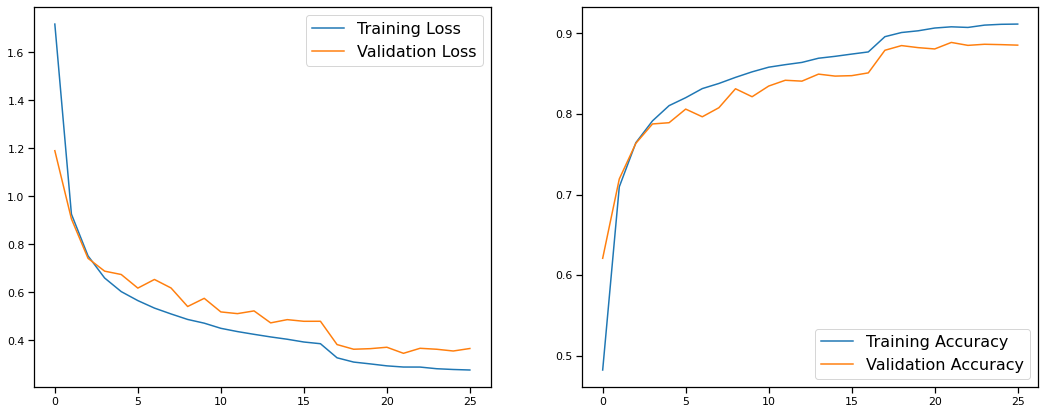

In [29]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

## Test 6

Input shape: (16000,)
Epoch 1/30
1482/1482 [==============================] - 83s 54ms/step - loss: 2.1915 - accuracy: 0.3634 - val_loss: 1.4894 - val_accuracy: 0.5271
Epoch 2/30
1482/1482 [==============================] - 82s 55ms/step - loss: 1.1746 - accuracy: 0.6296 - val_loss: 1.0253 - val_accuracy: 0.6690
Epoch 3/30
1482/1482 [==============================] - 79s 53ms/step - loss: 0.9217 - accuracy: 0.7106 - val_loss: 0.8998 - val_accuracy: 0.7128
Epoch 4/30
1482/1482 [==============================] - 80s 54ms/step - loss: 0.7969 - accuracy: 0.7488 - val_loss: 0.8125 - val_accuracy: 0.7387
Epoch 5/30
1482/1482 [==============================] - 78s 53ms/step - loss: 0.7121 - accuracy: 0.7747 - val_loss: 0.7634 - val_accuracy: 0.7628
Epoch 6/30
1482/1482 [==============================] - 79s 53ms/step - loss: 0.6586 - accuracy: 0.7923 - val_loss: 0.8448 - val_accuracy: 0.7500
Epoch 7/30
1482/1482 [==============================] - 81s 54ms/step - loss: 0.6118 - accuracy: 0.807

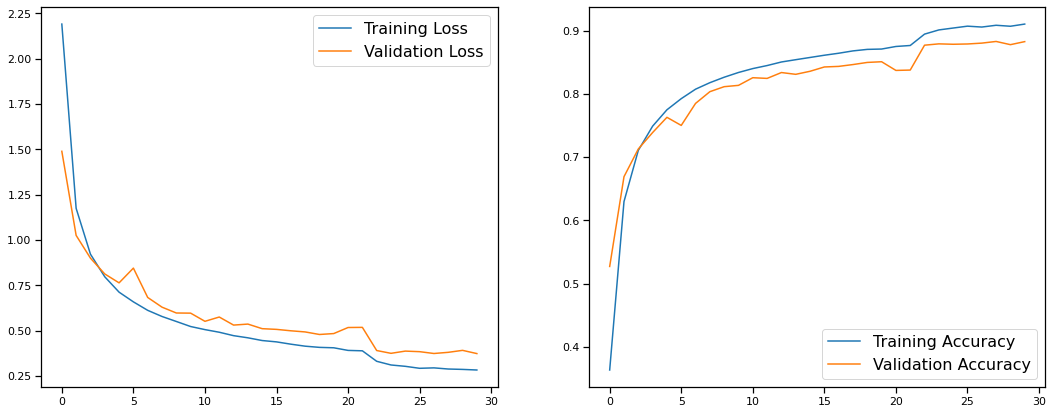

In [35]:
def kws_res_net_test6(ds, output_classes, model_suffix):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
#     X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC()(X_input)
    X = SpecAugment()(X)
    X = layers.BatchNormalization(axis=-1)(X)
    
    # Stage 1 
    X = layers.Conv2D(64, (10,10), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    
    X = convolutional_block(X, f = 2, filters = [64, 64, 64], stage = 2, block='c', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='d')
    
    X = convolutional_block(X, f = 1, filters = [64, 64, 64], stage = 2, block='e', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='f')
    
    X = convolutional_block(X, f = 1, filters = [64, 64, 64], stage = 2, block='g', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='h')
#     X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

    # AVGPOOL 
#     X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(len(output_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name="kws_res_net"+model_suffix)

    return model

model_res_net6 = kws_res_net_test6(train_dataset, output_classes, model_suffix="test")

model_res_net6.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model_res_net6.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

y_scores = model_res_net6.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()